In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
import math

In [2]:
#%%从万德下载下来的数据
etf_close=pd.read_excel("50ETF.xlsx","close")#50ETF，期间每个交易日的收盘价
etf_ivx=pd.read_excel("50ETF.xlsx","ivx")#ivx是波动率（隐含波动率）
etf_hv=pd.read_excel("50ETF.xlsx","hv30")#期权对应标的的30天历史波动率，用历史波动率与隐含波动率对比寻找交易机会
lastdate=pd.read_excel("50ETF.xlsx","ETF_option_lasttradingdate")#最后的交易日
etf_option_name=pd.read_excel("50ETF.xlsx","at_money_name")#记录每个日期相应平值期权对应的名字

In [5]:
#%%
##preprocessing，填补缺失值
#日期由近到远遍历缺失值，然后填补
for j in range(1,len(etf_close.columns.tolist())):
    for i in range(len(etf_close.date.values.tolist())-1,0,-1):
        if math.isnan(etf_close.iat[i,j]) and math.isnan(etf_close.iat[i-1,j]):
            etf_close.iat[i,j]= etf_close.iat[i+1,j]
        elif math.isnan(etf_close.iat[i,j]) and math.isnan(etf_close.iat[i-1,j])==False:
            etf_close.iat[i,j]=(etf_close.iat[i-1,j]+etf_close.iat[i+1,j])/2

In [6]:
fee = 5.0 #手续费设定为五元
slippage = 5.0 #滑点
capital = 1000000.0 #
size=50#每次做50手straddle
option_value=0 #期权默认初始值为0
remain_money=capital #账户现有资金，用于记录盈亏情况
total_money = [remain_money]
trade_option = pd.DataFrame()
### 回测参数设置
open_b = 1.5 #比实线波动率高多少倍的标准差就入场
close_b = 0.0001 #标准差为0.0001的时候选择平仓（因为趋势可能反转）

In [7]:
def add_open(num,call_name,put_name):#判断正在开仓的合约状态
    global trade_option
    if trade_option.empty:
        t = pd.Series([call_name,put_name,num], index=["call","put","size"])
        trade_option = trade_option.append(t, ignore_index=True)
    else:
        if call_name not in trade_option['call'].values:
            t = pd.Series([call_name,put_name,num], index=["call","put","size"])
            trade_option = trade_option.append(t, ignore_index=True)
    return trade_option

In [8]:
d = []#记录交易日期
trade_content = []#记录交易内容
trade_posit = []#记录状态

In [9]:
def straddle(date,posit,call_name,put_name):#资金处理，定义买卖跨式期权，回测利用收盘价交易
    global size,trade_option
    call_close = etf_close[etf_close.date==date][call_name].values[0]
    put_close = etf_close[etf_close.date==date][put_name].values[0]
    if posit=="buy": #买跨式期权
        num=size
        add_open(num,call_name,put_name)
        d.append(date)
        trade_posit.append("buy")
        trade_content.append('buy: ' + str(call_name) + ' and buy' + str(put_name))
        print(str(date) + 'buy: ' + str(call_name) + ' and buy ' + str(put_name))
        money_chg=-10000.0*size*call_close-10000.0*size*put_close
    elif posit=="sell":#卖跨式期权
        num=-size
        add_open(num,call_name,put_name)
        d.append(date)
        trade_posit.append("sell")
        trade_content.append( 'sell: ' + str(call_name) + ' and sell' + str(put_name))
        print(str(date) + 'sell: ' + str(call_name) + ' and sell ' + str(put_name))
        money_chg=10000.0*size*call_close+10000.0*size*put_close
    elif posit=="close buy":#冲销多头——卖出期权
        trade_option=trade_option[trade_option['call']!=call_name]
        d.append(date)
        trade_posit.append("close buy")
        trade_content.append( 'close buy: ' + str(call_name) + ' and sell' + str(put_name))
        print(str(date) + 'close buy: ' + str(call_name) + ' and close buy ' + str(put_name))
        money_chg=10000.0*size*call_close+10000.0*size*put_close
    elif posit=="close sell":#冲销空头——买入期权
        trade_option=trade_option[trade_option['call']!=call_name]
        d.append(date)
        trade_posit.append("close sell")
        trade_content.append( 'close sell: ' + str(call_name) + ' and buy' + str(put_name))
        print(str(date) + 'close sell: ' + str(call_name) + ' and close sell ' + str(put_name))
        money_chg=-10000.0*size*call_close-10000.0*size*put_close

    return money_chg - 2 * size * fee - 2 * size * slippage / 2.0 
#策略考虑了滑点，因为最终成交不一定是收盘价，应该在收盘价附近波动

### 可视化

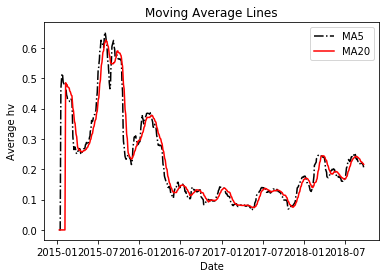

In [10]:
#构造长（20日）短（5日）均线
#短均线
ma5 = [0,0,0,0,0]
a = 0
for i in np.arange(5,905,1):
    ma5.append((etf_hv.hv[i-1]+etf_hv.hv[i-2]+etf_hv.hv[i-3]+etf_hv.hv[i-4]+etf_hv.hv[i-5])/5)#添加均线
#长均线    
ma20 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]#头20个都是0
b = 0
for i in np.arange(20,905,1):
    for j in np.arange(1,21):
        b += etf_hv.hv[i-j]
    ma20.append(b/20)
    b = 0


#plot ma5 and ma20
plt.title('Moving Average Lines')
plt.plot(etf_hv.date, ma5, linestyle = '-.',color='black', label='MA5')
plt.plot(etf_hv.date, ma20,color='red', label='MA20')
plt.legend() 
plt.xlabel('Date')
plt.ylabel('Average hv')
plt.savefig("MAL.png")
plt.show()

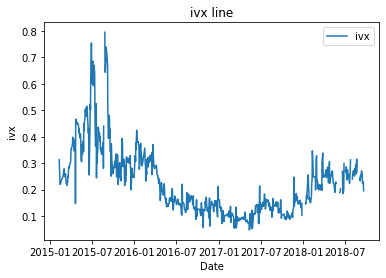

In [11]:
#计算ivx
#构造ivx曲线
ivxl = []
#计算ivx的函数
def cal_ivx(date):#平值期权的隐含波动率
    call_name=etf_option_name[etf_option_name.date==date]['call'].values[0]
    put_name=etf_option_name[etf_option_name.date==date]['put'].values[0]
    call_ivx = etf_ivx[etf_ivx.date==date][call_name].values[0]
    put_ivx = etf_ivx[etf_ivx.date==date][put_name].values[0]
    return ((call_ivx + put_ivx )/2)

### 画出平值附近期权的隐波
for date in etf_option_name.date.values:
    ivxl.append(cal_ivx(date))
    
        
#plot ivx
plt.title('ivx line')
plt.plot(etf_option_name.date, ivxl, label = 'ivx')
plt.legend()
plt.xlabel('Date')
plt.ylabel('ivx')
plt.savefig("ivx.png")
plt.show()

In [12]:
#连接成DataFrame
c = {"number":range(905), "date":etf_hv.date, "ma5":ma5, "ma20":ma20}
etf_hv1 = pd.DataFrame(c)

In [13]:
#计算hv的标准差(时段为20天)
hv30plus=etf_hv['hv'].values.tolist()
hv30_std = [(np.array(hv30plus)[i:i+20]).std() for i in range(len(hv30plus))]

In [14]:
#数据处理完成
#开仓平仓逻辑、交易
def handle_ivx(date):
    global remain_money
    hv = etf_hv[etf_hv.date==date]['hv'].values[0]
    hvstd = etf_hv[etf_hv.date==date]['hv_std'].values[0]
    call_name=etf_option_name[etf_option_name.date==date]['call'].values[0]
    put_name=etf_option_name[etf_option_name.date==date]['put'].values[0]
    call_ivx = etf_ivx[etf_ivx.date==date][call_name].values[0]
    put_ivx = etf_ivx[etf_ivx.date==date][put_name].values[0]
    ivx= (call_ivx + put_ivx )/2
    option_value=0
    number = int(etf_hv1[etf_hv1.date==date].number)
    
    ### 开仓： 条件加滤网，满足突破一定的标准差与突破自身段时间内波动率，因为入场条件是互斥的，所以用if，elif，else结构
    if trade_option.empty:
        if ivx > hv + open_b * hvstd and (ivx>etf_hv1.ma20[number]) :
            # 条件 + 滤网
            #如果现在隐含波动率大于20天内历史波动率+1.5倍历史波动率的标准差 & 现在的波动率大于过去20日均线的波动率
            call_close = etf_close[etf_close.date == date][call_name].values[0]
            put_close = etf_close[etf_close.date == date][put_name].values[0]
            posit = 'sell'
            change = straddle(date,posit,call_name,put_name) #记录消耗的资金
            option_value = option_value - 10000.0 * size * call_close - 10000.0 * size * put_close#记录期权价值
        elif ivx < hv - open_b * hvstd and (ivx<etf_hv1.ma20[number]):
            #入场条件现在隐含波动率是小于20天内历史波动率 - 1.5倍标准差 & 小于20天长均线的移动平均的均值
            call_close = etf_close[etf_close.date == date][call_name].values[0]
            put_close = etf_close[etf_close.date == date][put_name].values[0]
            posit = 'buy'
            change= straddle(date,posit,call_name,put_name)
            option_value = option_value + 10000.0 * size * call_close + 10000.0 *size * put_close
        else:
            change=0
    else:


    #平仓逻辑： 1.到期   2.波动率均值回归
        for call_name in trade_option['call']:
            num=trade_option[trade_option['call']==call_name]["size"].values.tolist()[0]
            put_name=trade_option[trade_option['call']==call_name]["put"].values.tolist()[0]

            if ( hv-close_b *hvstd < ivx < hv + close_b *hvstd or expire(call_name,date)=="T" )and num >0:
                #波动率回归正常
                posit = 'close buy'
                change = straddle(date,posit,call_name,put_name)
            elif (hv < ivx < etf_hv1.ma20[number]  or expire(call_name,date)=="T" )and num <0:
                #波动率回归正常，隐含波动率回归到了历史均值和20天移动均线的范围内，注意满足一个条件就平仓
                posit = 'close sell'
                change = straddle(date,posit,call_name,put_name)
            else:
                call_close = etf_close[etf_close.date == date][call_name].values[0]
                put_close = etf_close[etf_close.date == date][put_name].values[0]
                option_value=option_value+10000.0*num*call_close+10000.0*num*put_close
                change=0

    remain_money += change #结算
    total_money.append(remain_money + option_value) 
    #记录每天的资金变化，结算只有交易时候才会变化，option value一直都在变化，需要被记录下来

In [15]:
#判断看涨期权是否到期的函数
def expire(call_name,date):
    if date in lastdate.lasttradingdate.values and (call_name in lastdate[lastdate.lasttradingdate == date]['symbol'].values):
        expireTF="T"
    else:
        expireTF="F"
    return expireTF

In [16]:
day=[]#提取对应日期
for date in etf_option_name.date.values:
    handle_ivx(date)
    date=pd.to_datetime(str(date)).strftime('%Y-%m-%d') #date为字符串
    date = datetime.strptime(date, "%Y-%m-%d")
    day.append(date)

2015-02-12T00:00:00.000000000buy: 50ETF购2015年3月2.40 and buy 50ETF沽2015年3月2.40
2015-03-25T00:00:00.000000000close buy: 50ETF购2015年3月2.40 and close buy 50ETF沽2015年3月2.40
2015-04-08T00:00:00.000000000sell: 50ETF购2015年4月2.90 and sell 50ETF沽2015年4月2.90
2015-04-22T00:00:00.000000000close sell: 50ETF购2015年4月2.90 and close sell 50ETF沽2015年4月2.90
2015-04-23T00:00:00.000000000sell: 50ETF购2015年5月3.20 and sell 50ETF沽2015年5月3.20
2015-05-27T00:00:00.000000000close sell: 50ETF购2015年5月3.20 and close sell 50ETF沽2015年5月3.20
2015-05-28T00:00:00.000000000sell: 50ETF购2015年6月3.10 and sell 50ETF沽2015年6月3.10
2015-06-24T00:00:00.000000000close sell: 50ETF购2015年6月3.10 and close sell 50ETF沽2015年6月3.10
2015-06-25T00:00:00.000000000sell: 50ETF购2015年7月2.90 and sell 50ETF沽2015年7月2.90
2015-07-22T00:00:00.000000000close sell: 50ETF购2015年7月2.90 and close sell 50ETF沽2015年7月2.90
2015-07-23T00:00:00.000000000buy: 50ETF购2015年8月2.75 and buy 50ETF沽2015年8月2.80
2015-08-26T00:00:00.000000000close buy: 50ETF购2015年8月2.75 and clos

2018-01-17T00:00:00.000000000sell: 50ETF购2018年1月3.10 and sell 50ETF沽2018年1月3.10
2018-01-24T00:00:00.000000000close sell: 50ETF购2018年1月3.10 and close sell 50ETF沽2018年1月3.10
2018-01-25T00:00:00.000000000sell: 50ETF购2018年2月3.20 and sell 50ETF沽2018年2月3.20
2018-02-28T00:00:00.000000000close sell: 50ETF购2018年2月3.20 and close sell 50ETF沽2018年2月3.20
2018-03-15T00:00:00.000000000buy: 50ETF购2018年3月2.90 and buy 50ETF沽2018年3月2.90
2018-03-28T00:00:00.000000000close buy: 50ETF购2018年3月2.90 and close buy 50ETF沽2018年3月2.90
2018-03-29T00:00:00.000000000sell: 50ETF购2018年4月2.75 and sell 50ETF沽2018年4月2.75
2018-04-25T00:00:00.000000000close sell: 50ETF购2018年4月2.75 and close sell 50ETF沽2018年4月2.75
2018-04-27T00:00:00.000000000sell: 50ETF购2018年5月2.65 and sell 50ETF沽2018年5月2.65
2018-05-17T00:00:00.000000000close sell: 50ETF购2018年5月2.65 and close sell 50ETF沽2018年5月2.65
2018-05-18T00:00:00.000000000sell: 50ETF购2018年5月2.70 and sell 50ETF沽2018年5月2.70
2018-05-23T00:00:00.000000000close sell: 50ETF购2018年5月2.70 and c

In [18]:
DAY_MAX=len(total_money)
def cacul_performance():#查看回测表现
    """
    Calculate annualized return, Sharpe ratio, maximal drawdown, return volatility and sortino ratio
    :return: annualized return, Sharpe ratio, maximal drawdown, return volatility and sortino ratio
    """
    rtn = total_money[-1] / capital - 1
    #return，为（每天资金变化/初始资金） - 1
    annual_rtn = np.power(rtn + 1, 252.0 / DAY_MAX) - 1  #年化收益 复利
    annual_rtn = rtn * 252 / DAY_MAX  # 单利
    print(total_money)
    annual_lst = [(total_money[k + 1] - total_money[k]) / total_money[k] for k in range(DAY_MAX - 1)]
    annual_vol = np.array(annual_lst).std() * np.sqrt(252.0)

    rf = 0.04#自己定义的risk free rate

    semi_down_list = list(filter(lambda x: True if x < rf/252  else False, annual_lst))
    # semi_down_list = [annual_lst[k] < rf / 252 for k in range(trade_period - 1)]
    semi_down_vol = np.array(semi_down_list).std() * np.sqrt(252)
    sharpe_ratio = (annual_rtn - rf) / annual_vol
    sortino_ratio = (annual_rtn - rf) / semi_down_vol#把当天表现输给rf交易日的vol找出来

    max_drawdown_ratio = 0
    for e, i in enumerate(total_money):
        for f, j in enumerate(total_money):
            if f > e and float(j - i) / i < max_drawdown_ratio:
                max_drawdown_ratio = float(j - i) / i #记录最大回撤

    return annual_rtn, max_drawdown_ratio, annual_vol, sharpe_ratio, sortino_ratio

In [20]:
backtest_return = total_money[-1] / capital - 1
annulized, max_drawdown, rtn_vol, sharpe, sortino = cacul_performance()

[1000000.0, 1000000.0, 1000000.0, 999250.0, 987500.0, 985550.0, 988450.0, 984000.0, 987450.0, 987750.0, 988400.0, 982850.0, 979550.0, 980000.0, 975400.0, 969950.0, 967200.0, 962350.0, 964500.0, 964350.0, 976000.0, 986400.0, 1024150.0, 1014350.0, 1034900.0, 1049900.0, 1036500.0, 1019000.0, 1019000.0, 1019000.0, 1019000.0, 1019000.0, 1019000.0, 1019000.0, 1019000.0, 1019000.0, 1018250.0, 1015200.0, 1022050.0, 1021900.0, 1029800.0, 1024000.0, 978950.0, 955850.0, 998200.0, 985200.0, 938400.0, 937650.0, 940550.0, 948550.0, 954750.0, 956400.0, 960350.0, 974350.0, 979850.0, 980250.0, 973000.0, 981750.0, 1005650.0, 1009000.0, 1008400.0, 1016900.0, 1008450.0, 983450.0, 1029700.0, 1030050.0, 1049350.0, 1066000.0, 1060200.0, 1055950.0, 1075450.0, 1074700.0, 1068700.0, 1063250.0, 1054400.0, 1064200.0, 1059550.0, 1057150.0, 1021500.0, 1045200.0, 1064350.0, 1067400.0, 1075600.0, 1117100.0, 1137450.0, 1135350.0, 1156200.0, 1110200.0, 1153800.0, 1175250.0, 1174500.0, 1129500.0, 1093350.0, 1145350.0, 1

In [21]:
## 回测绩效与绘图
print('Return: %.2f%%' % (backtest_return * 100.0))
print('Annualized Return: %.2f%%' % (annulized * 100.0))
print('Maximal Drawdown: %.2f%%' % (max_drawdown * 100.0))
print('Annualized Vol: %.2f%%' % (100.0 * rtn_vol))
print('Sharpe Ratio: %.4f' % sharpe)
print('Sortino Ratio: %.4f' % sortino)

Return: 99.03%
Annualized Return: 28.20%
Maximal Drawdown: -10.69%
Annualized Vol: 14.78%
Sharpe Ratio: 1.6371
Sortino Ratio: 2.3588


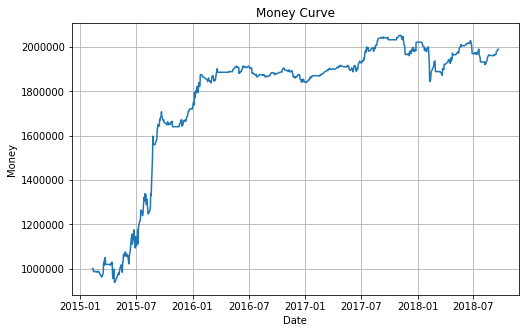

In [22]:
#sns.set_style('white')
plt.figure(figsize=(8, 5))
plt.plot(day, total_money[1:])
plt.xlabel('Date')
plt.ylabel('Money')
plt.title('Money Curve')
plt.grid(True)
plt.savefig("result.png")
plt.show()